# PLEASE NOTE THAT I ACCIDENTALLY UPLOADED THE WRONG EMBEDDINGS OVER HERE. THIS IS MT0 BASED, NOT MT5

In [2]:
import os, joblib
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import torch
import torch.distributed as dist 
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# !cd /kaggle/working/models/
# !rm -rf *

In [3]:
# !mkdir models
# !ls /kaggle/working/models/
!ls /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
!ls /kaggle/input/pashto-poetry/data/

abbasinYousuf	karanKhan	    mumtazOrakazi   salimRiaz
ajmalKhattak	khaliqZiari	    munirJan	    shabbirKhanDurrani
allamaAbdulHai	khatirAfridi	    naeemAhmed	    shakirOrakzai
azizMazerwal	khayyamYousufzai    rabiaMumtaz     shoaibKhanKhattak
ghaniKhan	khushalKhanKhattak  rahmanBaba
hamzaBaba	matiullahTurab	    rehmatShah
javedAhmedzai	mohammadAjanyar     sahibShahSabir


In [5]:
# Define Data directory
DATA_DIR = '/kaggle/input/pashto-poetry/data/'

# list of poet names
# Removed the 5 lowest poets
poets = ["abbasinYousuf", "ajmalKhattak", "allamaAbdulHai", "ghaniKhan", "hamzaBaba", "javedAhmedzai", "karanKhan", "khatirAfridi", "khushalKhanKhattak", "matiullahTurab", "mumtazOrakazi", "munirJan", "naeemAhmed", "rabiaMumtaz", "rahmanBaba", "rehmatShah", "sahibShahSabir", "shabbirKhanDurrani", "shakirOrakzai", "shoaibKhanKhattak"]

poet_labels = {poet: i for i, poet in enumerate(poets)}
print(poet_labels)

{'abbasinYousuf': 0, 'ajmalKhattak': 1, 'allamaAbdulHai': 2, 'ghaniKhan': 3, 'hamzaBaba': 4, 'javedAhmedzai': 5, 'karanKhan': 6, 'khatirAfridi': 7, 'khushalKhanKhattak': 8, 'matiullahTurab': 9, 'mumtazOrakazi': 10, 'munirJan': 11, 'naeemAhmed': 12, 'rabiaMumtaz': 13, 'rahmanBaba': 14, 'rehmatShah': 15, 'sahibShahSabir': 16, 'shabbirKhanDurrani': 17, 'shakirOrakzai': 18, 'shoaibKhanKhattak': 19}


In [6]:
# Load and Label the Data
def load_and_label(data_dir, poets, poet_labels):
    data = []
    labels = []

    for poet in poets:
        poet_dir = os.path.join(data_dir, poet)
        file_path = os.path.join(poet_dir, f'{poet}.txt')

        # Check if the file exists
        if not os.path.exists(file_path):
            print(f'{file_path} does not exist')
            continue

        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            data.extend(lines)
            labels.extend([poet_labels[poet]] * len(lines))

    df = pd.DataFrame({'text': data, 'label': labels})
    return data, labels, df

In [7]:
data, labels, df = load_and_label(DATA_DIR, poets, poet_labels)
df.describe()

label
count  54620.000000
mean       8.625265
std        5.352617
min        0.000000
25%        4.000000
50%        8.000000
75%       14.000000
max       19.000000

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
model = AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
model.to(device)

In [9]:
poems_train, poems_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

In [10]:
def save_embeddings(texts, prefix, model, tokenizer, device, max_length=80):
    encoder = model.get_encoder()  # Get only the encoder part of the model
    
    for i, text in enumerate(texts):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():
            encoder_outputs = encoder(**inputs)
            # Use the mean of the last hidden state as the embedding
            embedding = encoder_outputs.last_hidden_state.mean(dim=1).to(device)
        
        torch.save(embedding, f'./models_mt5_mult/{prefix}_embedding_{i}.pt')
        if i % 100 == 0:
            print(f"{prefix.capitalize()} Embedding {i} saved.")


In [ ]:
# Save embeddings for train, test and validation
save_embeddings(poems_train, 'train', model, tokenizer, device)
save_embeddings(poems_val, 'val', model, tokenizer, device)
save_embeddings(poems_test, 'test', model, tokenizer, device)

In [11]:
!ls /kaggle/input/mt5-multilingual-embeddings/pytorch/default/1/models_mt5_mult

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


test_embedding_0.pt	  train_embedding_21468.pt  train_embedding_37855.pt
test_embedding_1.pt	  train_embedding_21469.pt  train_embedding_37856.pt
test_embedding_10.pt	  train_embedding_2147.pt   train_embedding_37857.pt
test_embedding_100.pt	  train_embedding_21470.pt  train_embedding_37858.pt
test_embedding_1000.pt	  train_embedding_21471.pt  train_embedding_37859.pt
test_embedding_1001.pt	  train_embedding_21472.pt  train_embedding_3786.pt
test_embedding_1002.pt	  train_embedding_21473.pt  train_embedding_37860.pt
test_embedding_1003.pt	  train_embedding_21474.pt  train_embedding_37861.pt
test_embedding_1004.pt	  train_embedding_21475.pt  train_embedding_37862.pt
test_embedding_1005.pt	  train_embedding_21476.pt  train_embedding_37863.pt
test_embedding_1006.pt	  train_embedding_21477.pt  train_embedding_37864.pt
test_embedding_1007.pt	  train_embedding_21478.pt  train_embedding_37865.pt
test_embedding_1008.pt	  train_embedding_21479.pt  train_embedding_37866.pt
test_embedding_1009.pt

In [12]:
class_labels = sorted(list(set(labels_train)))

def load_embeddings(prefix, num_embeddings):
    embeddings = []
    for i in range(num_embeddings):
        embedding = torch.load(f'../../kaggle/input/mt5-multilingual-embeddings/pytorch/default/1/models_mt5_mult/{prefix}_embedding_{i}.pt')
        embeddings.append(embedding)
    return torch.stack(embeddings)

In [13]:
train_embeddings = load_embeddings('train', len(poems_train))
train_embeddings

/tmp/ipykernel_30/2481312617.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/mt5-multilingual-embeddings/pytorch/default/1/mo

tensor([[[ 0.0670, -0.0291,  0.0244,  ..., -0.0240, -0.0955, -0.0224]],

        [[ 0.0373,  0.0009, -0.0094,  ..., -0.0073,  0.0105, -0.0785]],

        [[ 0.0094, -0.0078, -0.0234,  ...,  0.0138, -0.0241, -0.0540]],

        ...,

        [[-0.0787, -0.0267, -0.0219,  ...,  0.0148, -0.0409, -0.0257]],

        [[ 0.0954, -0.0110, -0.0713,  ..., -0.0482, -0.0637, -0.0447]],

        [[-0.0513, -0.0093,  0.0465,  ..., -0.0568, -0.0506, -0.0384]]])

In [14]:
val_embeddings = load_embeddings('val', len(poems_val))
val_embeddings

/tmp/ipykernel_30/2481312617.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/mt5-multilingual-embeddings/pytorch/default/1/mo

tensor([[[ 0.1025,  0.0435,  0.0173,  ...,  0.0376,  0.0022, -0.0269]],

        [[ 0.0954, -0.0104, -0.0163,  ...,  0.0475, -0.0493, -0.0427]],

        [[ 0.1116, -0.0025,  0.0315,  ..., -0.0009, -0.0216, -0.0854]],

        ...,

        [[ 0.0523,  0.0374, -0.0430,  ..., -0.0221, -0.0456, -0.0523]],

        [[ 0.0209,  0.0415, -0.0365,  ..., -0.0350, -0.0529, -0.0166]],

        [[ 0.0370, -0.0313,  0.0047,  ..., -0.0274, -0.0350, -0.0433]]])

In [15]:
test_embeddings = load_embeddings('test', len(poems_test))
test_embeddings

/tmp/ipykernel_30/2481312617.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/mt5-multilingual-embeddings/pytorch/default/1/mo

tensor([[[ 0.0120,  0.0223,  0.0070,  ..., -0.0371, -0.0438, -0.0502]],

        [[ 0.0742, -0.0515, -0.0059,  ..., -0.0195, -0.0175, -0.0704]],

        [[ 0.0880,  0.0201,  0.0076,  ..., -0.0233, -0.0708, -0.0302]],

        ...,

        [[ 0.0415, -0.0263, -0.0155,  ...,  0.0624, -0.1147, -0.0328]],

        [[ 0.0069, -0.0253, -0.0477,  ...,  0.0454, -0.0728, -0.0153]],

        [[ 0.0272,  0.0192, -0.0122,  ..., -0.0158,  0.0003, -0.0198]]])

In [159]:
train_labels = torch.tensor(labels_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# encoded_labels = label_encoder.fit_transform(lables_train)

In [160]:
train_embeddings_np = train_embeddings.detach().numpy()
val_embeddings_np = val_embeddings.detach().numpy()
test_embeddings_np = test_embeddings.detach().numpy()
labels_train_np = np.array(labels_train)
# labels_train_np = np.array(poems_train)
labels_val_np = np.array(labels_val)
labels_test_np = np.array(labels_test)

In [161]:
train_embeddings_np.shape, val_embeddings_np.shape, test_embeddings_np.shape, labels_train_np.shape, labels_val_np.shape, labels_test_np.shape

((43696, 1, 768), (5462, 1, 768), (5462, 1, 768), (43696,), (5462,), (5462,))

In [162]:
# class PoemClassifier(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(PoemClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_size, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, output_size)
#         self.drop = nn.Dropout(0.3)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         if len(x.shape) > 2:
#             x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.drop(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         return x

class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten along the sequence length dimension
        x = F.relu(x)
        x = self.fc(x)
        return x

# class PoemClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
#         super(PoemClassifier, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(dropout)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         lstm_out, (hn, cn) = self.lstm(x)
#         last_hidden_state = hn[-1]
#         x = self.fc(self.dropout(last_hidden_state))
#         return x

In [163]:
# Set the input size based on the size of the embeddings
input_size = train_embeddings.size(2)  # Use size(2) instead of size(1)

# classifier = PoemClassifier(input_size=input_size, hidden_size=128, output_size=len(labels)).to(device)

# Initialize the classifier and move it to the device
classifier = PoemClassifier(input_size, len(set(labels)))
classifier.to(device)

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     classifier=nn.DataParallel(classifier)


# # Define the optimizer and loss function
# optimizer = optim.Adam(classifier.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# # Define the optimizer and loss function
# optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)
# criterion = nn.CrossEntropyLoss()

# Acha chal raha tha ye
# Define the optimizer and loss function
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# # Define the optimizer and loss function
# optimizer = optim.RMSprop(classifier.parameters(), lr=0.001, alpha=0.9)
# criterion = nn.CrossEntropyLoss()

# Create DataLoader for training to iterate over the embeddings and labels in batches.
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# # set the input size based on the size of the embeddings
# input_size = train_embeddings.size(2)

# # initialize the classifier and move it to the device
# classifier = PoemClassifier(input_size, len(labels)).to(device)
# # classifier = PoemClassifier(input_size, len(class_labels)).to(device)
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     classifier = nn.DataParallel(classifier)

# # Define the optimizer and loss function
# optimizer = optim.Adam(classifier.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# # Create dataloader for training to iterate over the embeddings and labels in batches
# train_dataset = TensorDataset(train_embeddings, train_labels)
# # train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [164]:
val_accuracies = []
train_accuracies = []
best_val_loss = float('inf')
patience = 5  # You can adjust this based on your needs
counter = 0
train_losses = []  # Track training loss
val_losses = []

In [167]:
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(TensorDataset(val_embeddings, val_labels), batch_size = 8)
# accumalation_steps = 4
# Create DataLoader for training to iterate over the embeddings and labels in batches.
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [168]:
# train_loader, val_loader
train_loader

In [169]:
# Training loop with early stopping
num_epochs = 200
for epoch in range(num_epochs):
    classifier.train()
    epoch_loss=0

    for batch_embeddings, batch_labels in train_loader:
      batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

      # Forward pass
      outputs = classifier(batch_embeddings)
      loss = criterion(outputs, batch_labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    # Average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Training accuracy
    with torch.no_grad():
        classifier.eval()
        train_outputs = classifier(train_embeddings.to(device))
        train_probabilities = F.softmax(train_outputs, dim=1)
        train_predicted_labels = torch.argmax(train_probabilities, dim=1).tolist()
        train_accuracy = accuracy_score(train_labels, train_predicted_labels)
        train_accuracies.append(train_accuracy)
    # Validation
    with torch.no_grad():
        classifier.eval()
        val_outputs = classifier(val_embeddings.to(device))
        val_loss = criterion(val_outputs, val_labels.to(device))
        val_losses.append(val_loss.item())


        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1


        val_probabilities = F.softmax(val_outputs, dim=1)
        val_predicted_labels = torch.argmax(val_probabilities, dim=1).tolist()
        val_accuracy = accuracy_score(val_labels, val_predicted_labels)
        val_accuracies.append(val_accuracy)

        # Print the current status
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered!")
            break

Epoch [1/200], Loss: 2.6047, Validation Loss: 2.4467
Epoch [2/200], Loss: 1.8197, Validation Loss: 2.2841
Epoch [3/200], Loss: 1.9163, Validation Loss: 2.1888
Epoch [4/200], Loss: 2.6097, Validation Loss: 2.1270
Epoch [5/200], Loss: 2.1664, Validation Loss: 2.0844
Epoch [6/200], Loss: 2.3214, Validation Loss: 2.0446
Epoch [7/200], Loss: 1.9051, Validation Loss: 2.0143
Epoch [8/200], Loss: 1.9112, Validation Loss: 1.9923
Epoch [9/200], Loss: 1.4752, Validation Loss: 1.9687
Epoch [10/200], Loss: 1.6549, Validation Loss: 1.9496
Epoch [11/200], Loss: 2.4016, Validation Loss: 1.9337
Epoch [12/200], Loss: 1.5298, Validation Loss: 1.9157
Epoch [13/200], Loss: 1.5273, Validation Loss: 1.9047
Epoch [14/200], Loss: 1.1289, Validation Loss: 1.8895
Epoch [15/200], Loss: 2.5130, Validation Loss: 1.8790
Epoch [16/200], Loss: 2.2687, Validation Loss: 1.8688
Epoch [17/200], Loss: 1.4253, Validation Loss: 1.8598
Epoch [18/200], Loss: 1.3877, Validation Loss: 1.8498
Epoch [19/200], Loss: 1.2799, Validat

In [172]:
# evaluation on the test set
with torch.no_grad():
    classifier.eval()
    test_outputs = classifier(test_embeddings.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))

    # convert logits to probs
    test_probabilities = F.softmax(test_outputs, dim=1)

    # get the predicted labels
    test_predicted_labels = torch.argmax(test_probabilities, dim=1).tolist()

    cm = confusion_matrix(test_labels, test_predicted_labels)

    # calculate the accuracy
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    test_loss_value = test_loss.item()

Test Accuracy: 0.5024


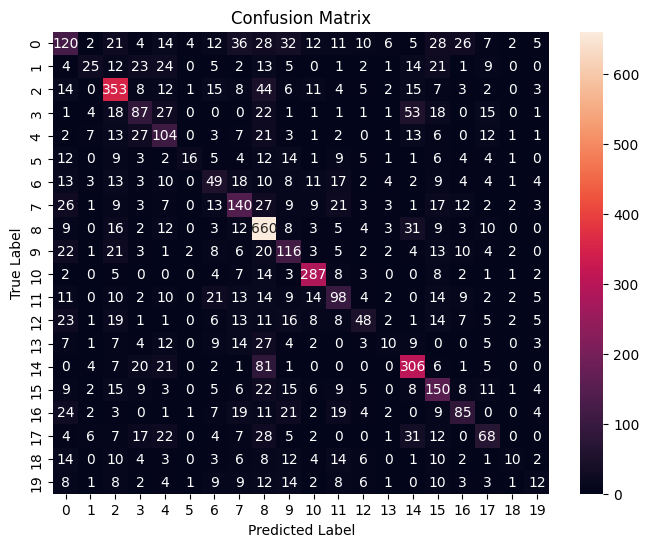

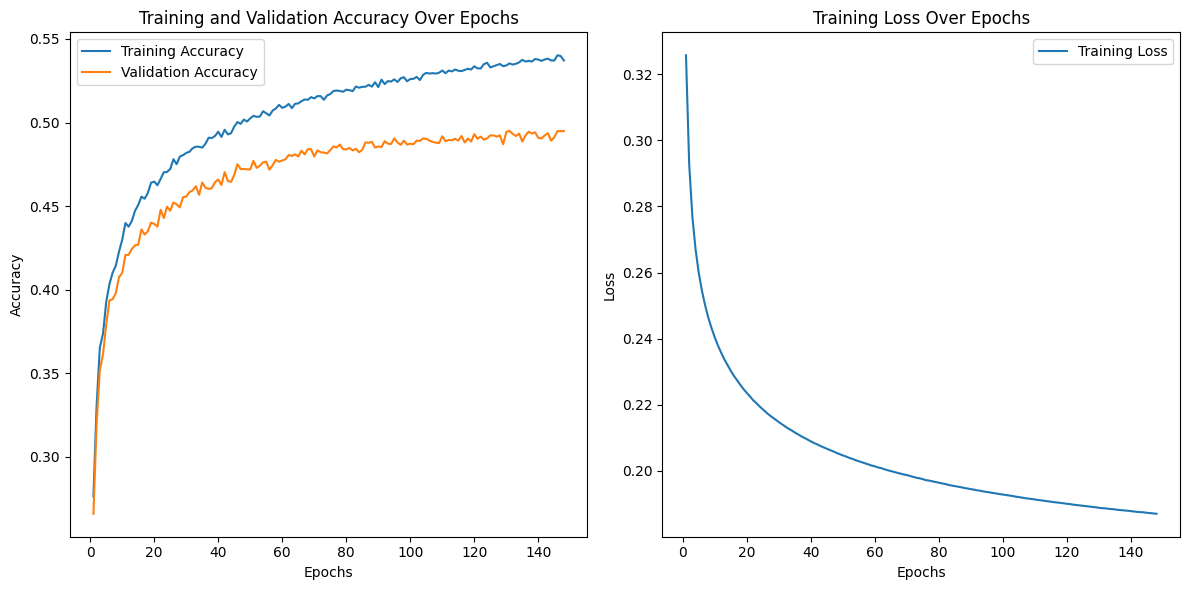

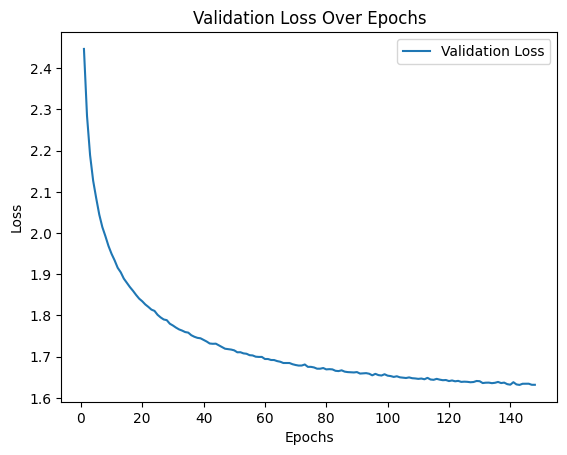

In [173]:
# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()